# In-Space Assembly Mini Thesis

# temp

In [190]:
# GENERAL SETTINGS
times = list(range(80))
arms = list(range(1))
state_capacity_common = [0,1,1,1,99]
# DELIVERY SETTINGS
delivery_sizes_hab = list(range(2))
delivery_frequencies = [5,30]
delivery_capacities_truss = [[8,1],[16,2]] # [to state 1, to state 2] for each delivery method
delivery_capacities_hab = [4,8] # [to state 1A, to state 1B] for each delivery method
# TRUSS SETTINGS
truss_pieces_per_arm = 8
states_for_truss = list(range(5))  # including source sink
states_for_truss_delivery = [1,2]  # states at which pieces can arrive from source
states_for_truss_precedence = [2,3]  # state origins where precedence is enforced
states_for_truss_simul = [1,2,3]  # state origins where we care about simultaneity accross arms
state_duration_truss = [0,3,5,2,0]  # duration to next state
state_storage_truss = [0,16,4,4,0]
state_capacity_truss = [0,1,1,1,99]
# HAB SETTINGS
angle_per_arm= 90
states_for_hab = list(range(5)) # including source sink
states_for_hab_precedence = [2,3] # states where precedence is enforced
states_for_hab_simul = [2,3] # state origins where we care about simultaneity accross arms
state_duration_hab = [0,0,3,1,0]
state_storage_hab = [[0,0,4,4,0], [0,0,8,8,0]]
state_capacity_hab = [[0,0,4,4,99], [0,0,8,8,99]] # second one used for cross-size
state_capacity_hab_bin = [0,1,1,1,99]
# COSTS SETTINGS
delivery_costs = [1000,1500]  # first freq, second freq
storage_costs_truss = [0,0.01,0.02,0.03,0]
storage_costs_hab = [0,0.01,0.02,0.03,0]
time_cost = 1


In [191]:
def create_deliveries():
    d = [0 for _ in times]
    t = [[0] * len(times) for _ in delivery_frequencies]
    h = [0] * len(times)

    for i in range(len(times)):
        for x, freq in enumerate(delivery_frequencies):
            if i % freq == 0:
                d[i] = 1
                h[i] = delivery_capacities_hab[x]
                for j in range(len(states_for_truss_delivery)):
                    t[j][i] = delivery_capacities_truss[x][j]

    return d, t, h

days_with_delivery, delivery_cap_truss, delivery_cap_hab = create_deliveries()

In [192]:
# TRUSS
# create nodes for truss
nodes_for_truss = [(s, t) for s in states_for_truss for t in times if s > 0]
# add sink
nodes_for_truss.append((max(states_for_truss) + 1, max(times)))
# create arcs across same state to t+1
arcs_for_truss = [(n, (n[0], n[1] + 1)) for n in nodes_for_truss if (n[1] + 1 in times and state_storage_truss[n[0]]!=0)]
# add arcs between states with duration specified
for i, dur in enumerate(state_duration_truss):
    arcs_for_truss.extend([(n, (n[0] + 1, n[1] + dur)) for n in nodes_for_truss if(n[0] == i and n[0] + 1 in states_for_truss and n[1] + dur in times)])
# add arcs to sink
for n in nodes_for_truss:
    if n[0] == max(states_for_truss):
        arcs_for_truss.append((n, (max(states_for_truss) + 1, max(times))))
# insert source node
nodes_for_truss.insert(0, (0, 0))
# add delivery arcs
for i, val in enumerate(days_with_delivery):
    if bool(val):
        for x, j in enumerate(states_for_truss_delivery):
            if delivery_cap_truss[x][i] > 0:
                arcs_for_truss.append(((0, 0), (j, i)))


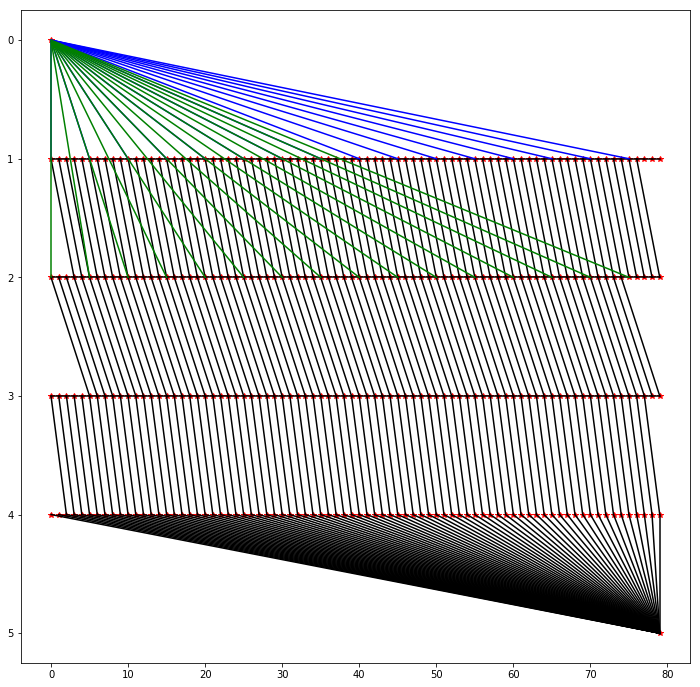

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline
############ SEPARATE PLOT ALL ARCS #############
x_val = [x[0] for x in nodes_for_truss]
y_val = [x[1] for x in nodes_for_truss]
colors = ['blue', 'green']
plt.figure(figsize=(12,12))
for tr in arms:
    # TRUSS PIECES
    plt.gca().invert_yaxis()
    plt.plot(y_val, x_val, 'r*')
    for ori,dest in arcs_for_truss:
        if ori[0] == 0:
            for j in range(len(states_for_truss_delivery)):
                if dest[0] == states_for_truss_delivery[j]:
                    plt.plot([ori[1], dest[1]], [ori[0], dest[0]], color=colors[j])
        else:
            plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'k')

In [194]:
inflow_truss = {}
for n in nodes_for_truss:
    inflow_truss[n] = 0
inflow_truss[(0, 0)] = truss_pieces_per_arm
inflow_truss[(max(states_for_truss) + 1, max(times))] = -truss_pieces_per_arm


# Start Pulp stuff

In [195]:
import pulp as plp
opt_model = plp.LpProblem(name="MIP Model")
truss_network_vars  = {(ori,dest):
plp.LpVariable(cat=plp.LpInteger, 
               lowBound=0, upBound=10,
               name="arc_{0}_{1}".format(ori,dest)) 
for ori,dest in arcs_for_truss}

for n in nodes_for_truss:
    opt_model += plp.lpSum(truss_network_vars[ori,dest] for ori,dest in [a for a in arcs_for_truss if a[1]==n]) + inflow_truss[n] == plp.lpSum(truss_network_vars[ori,dest] for ori,dest in [a for a in arcs_for_truss if a[0]==n]), "node_conservation_{}".format(n)
    
    
for t in times:
    arcs_to_relate = [a for a in arcs_for_truss if
                      ((a[0][0] in states_for_truss_precedence and not a[1][0]==min(states_for_truss_precedence) and a[0][1] <= t and a[1][1] > t))]
    opt_model += plp.lpSum(truss_network_vars[ori,dest] for ori,dest in arcs_to_relate) <=1, "precedence_{}".format(t)

objective = plp.lpSum(truss_network_vars[ori,dest]*dest[1] for ori,dest in arcs_for_truss)
opt_model.sense = plp.LpMinimize
opt_model.setObjective(objective)

opt_model.writeLP("WhiskasModel.lp")


In [196]:
opt_model.solve()
print("Status:", plp.LpStatus[opt_model.status])


Status: Optimal


storage happened (1, 0) (1, 1) 1.0
storage happened (1, 1) (1, 2) 1.0
storage happened (1, 2) (1, 3) 1.0
storage happened (1, 3) (1, 4) 1.0
storage happened (1, 10) (1, 11) 1.0
storage happened (2, 20) (2, 21) 1.0


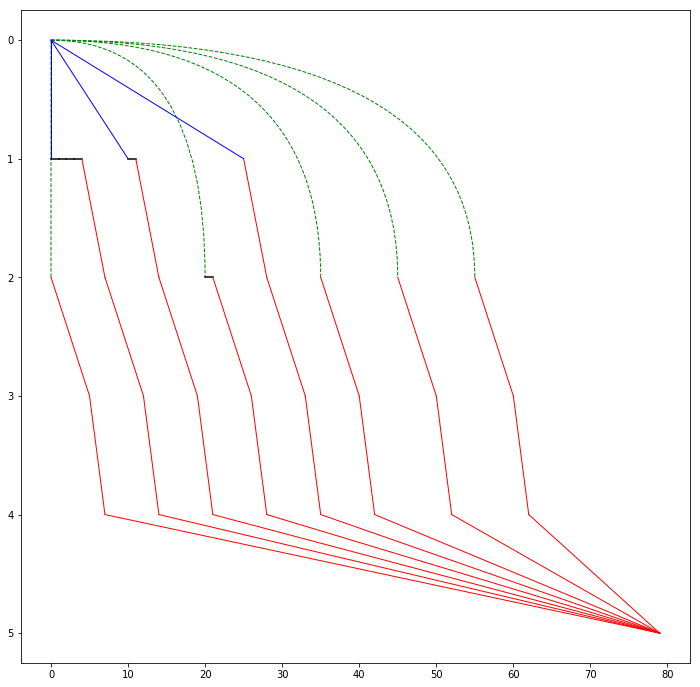

In [236]:
def draw_curved_delivery(ori, dest):
    import matplotlib.path as mpath
    import matplotlib.patches as mpatches

    Path = mpath.Path
    pp = mpatches.PathPatch(
        Path([(ori[1], ori[0]), (dest[1], ori[0]), (dest[1], dest[0])],
             [Path.MOVETO, Path.CURVE3, Path.CURVE3]),
        fc="none", transform=ax.transData, color='green', ls='--')
    
    return pp
            
colors = ['blue', 'green']
fig, ax = plt.subplots(figsize=(12,12))
# TRUSS PIECES
plt.gca().invert_yaxis()
# plt.plot(y_val, x_val, 'r*')
for ori,dest in arcs_for_truss:
    if plp.value(truss_network_vars[ori,dest]) > 0:
        if ori[0] == 0:
            if dest[0] == 1:
                plt.plot([ori[1], dest[1]], [ori[0], dest[0]], color=colors[0], linewidth=plp.value(truss_network_vars[ori,dest]))
            else:
                pp = draw_curved_delivery(ori, dest)
                ax.add_patch(pp)
        elif ori[0]!=dest[0]:
            plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'r', linewidth=plp.value(truss_network_vars[ori,dest]))
        else:
            print('storage happened', ori, dest, plp.value(truss_network_vars[ori,dest]))
            plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'k')